# Introduction

Principal Components Analysis (PCA) serves as a widely adopted dimension reduction algorithm, and within the scope of this project, it has been applied to well logs acquired from the Parque das Baleias' field. By diminishing the dimensions of the well logs, a subsequent reconstruction phase is executed, followed by the computation of the reconstruction error.

PCA operates by identifying the principal components, which are vectors that capture the maximum variance within the data. The first principal component represents the direction in the data space where the variance is the highest. Subsequently, the second component encapsulates the maximum remaining variance, and this pattern continues for successive components.

In PCA, the primary goal is to transform the original data into a new coordinate system defined by these principal components. Each principal component is orthogonal to the others, ensuring that they are uncorrelated. This property allows for a more efficient representation of the data, emphasizing the dominant patterns while discarding less relevant information.

Moreover, the reconstruction error, calculated after reducing and then reconstructing the data, quantifies the accuracy of the dimensionality reduction process. This error metric is pivotal in assessing how well the essential information in the original well logs is retained during the reduction process, providing insights into the effectiveness of PCA in capturing the significant variability in the dataset.

# PCA Steps

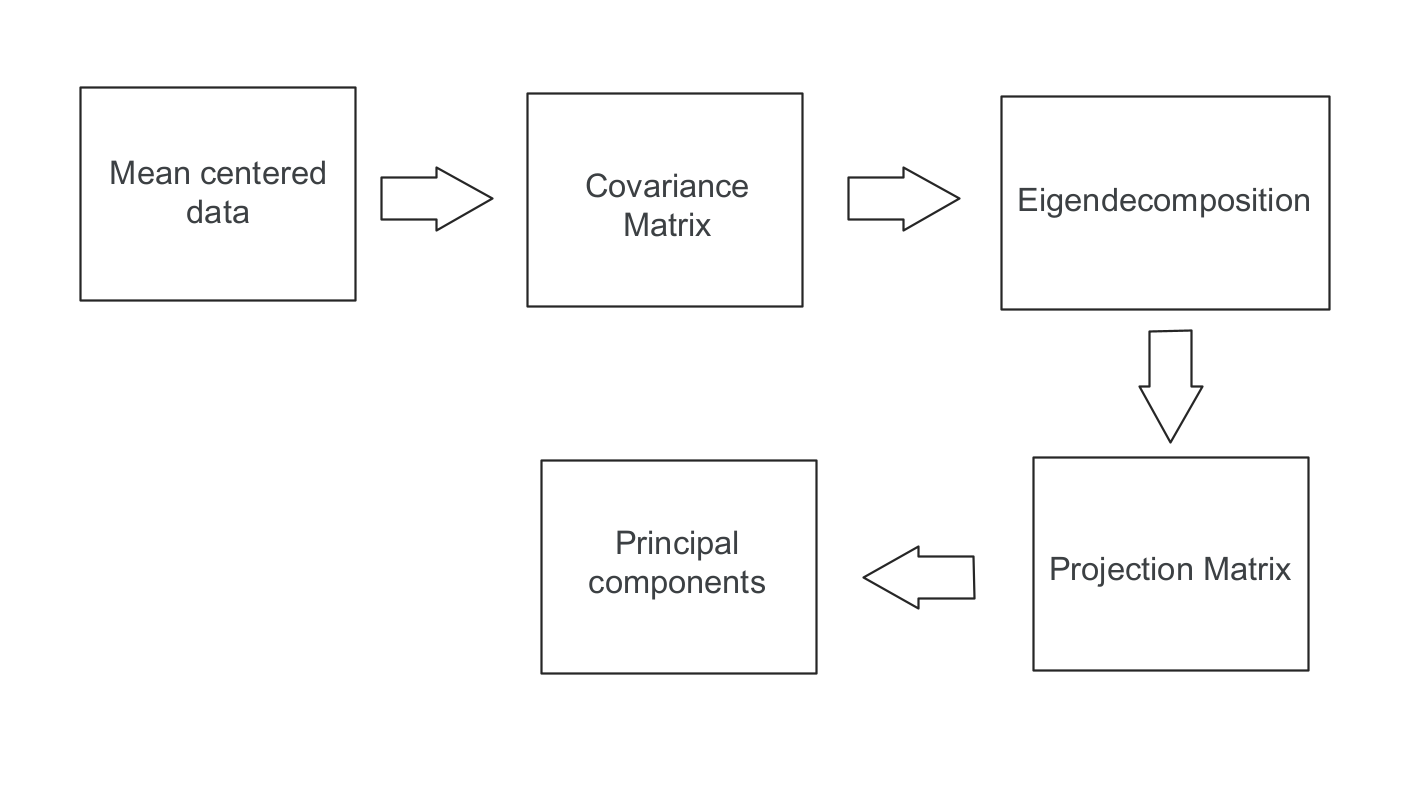

In [21]:
import numpy as np
import pandas as pd
import welly
import matplotlib.pyplot as plt

In [22]:
# --- 1. Well data importation --- #

# Well las files path
las_files = ["data/1-BRSA-192-ESS_Default_final.las", "data/3-BRSA-168-ESS_Default_final.las",
             "data/4-BRSA-449-ESS_Default_final.las",
            "data/6-BRSA-497-ESS_Default_final.las", "data/4-BRSA-291D-ESS_Default_final.las",
             "data/1-BRSA-33-ESS_Default_final.las", "data/1-BRSA-196-ESS_Default_final.las",
             "data/3-BRSA-277-ESS_Default_final.las", "data/3-BRSA-177-ESS_Default_final.las",
            ]

# Import well data
wells = []
for las_file in las_files:
    well = welly.Well.from_las(las_file)
    wells.append(well)

#create a welly project object with wells imported
project = welly.Project(wells)

In [23]:
# --- 2. Create density data matrix --- #

depth_interval = range(2600, 2650)
M = len(depth_interval)
N = len(las_files)
rhob_matrix = np.zeros((M, N))

well_logs_names = ['RHOB']
for i in range(N):
    well = project[i]
    well_df = well.df(keys=well_logs_names, basis=depth_interval)
    rhob_data = np.array(well_df.RHOB.values)
    rhob_matrix[:,i] = rhob_data
    
print(rhob_matrix.shape)

    


(50, 9)


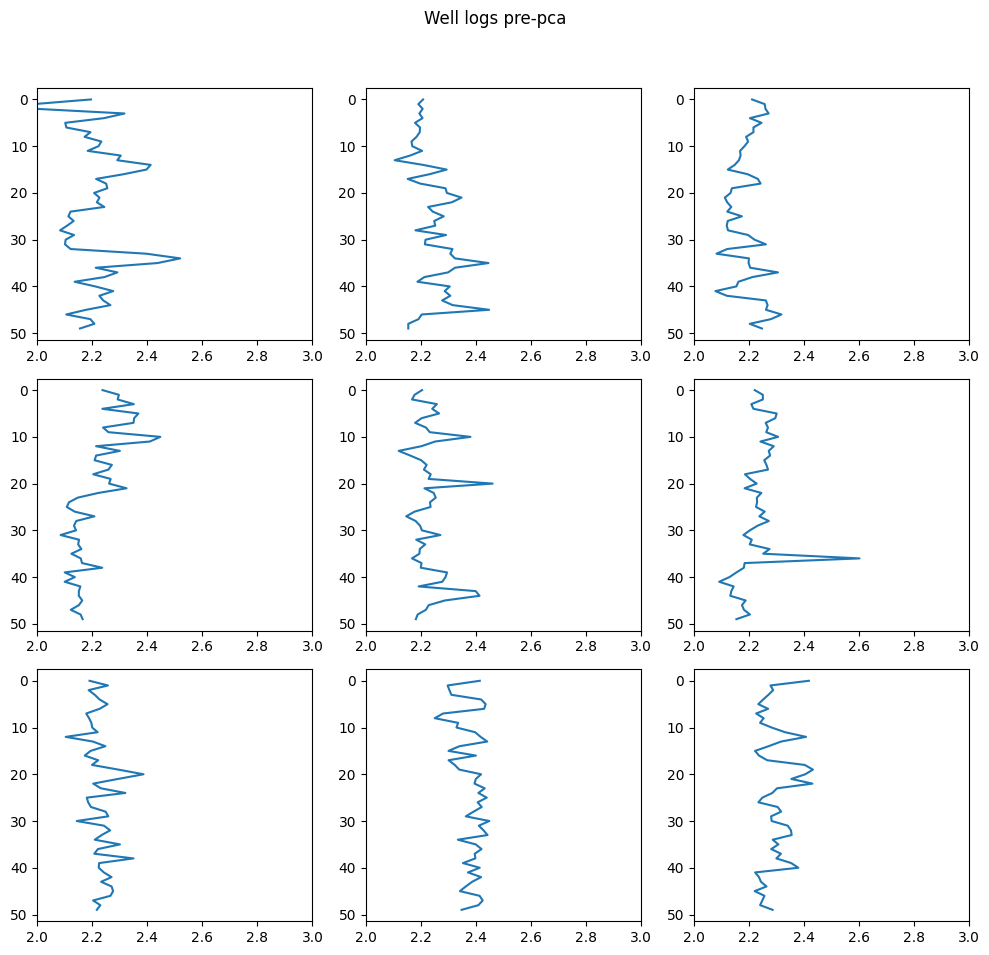

In [24]:
# --- 3. Well log plotting --- #

pre_pca_xlim = [2, 3]
pos_pca_xlim = [-1, 1]

def plot_logs_images(rhob_matrix, xlim, title=''):
  

  rhob_matrix = rhob_matrix.tolist()
  rhob_well_logs = list(map(list, zip(*rhob_matrix)))
  

  plt.figure(figsize=(10,10))
  
  for i in range(len(rhob_well_logs)):
    plt.subplot(3,3,i+1)
    image = rhob_well_logs[i]
    plt.plot(image, range(len(image)))
    plt.xlim(xlim)
    plt.gca().invert_yaxis()
    plt.suptitle(title)

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plot_logs_images(rhob_matrix, pre_pca_xlim, title='Well logs pre-pca')


In [25]:
# --- 4. PCA algorithm --- #


# PCA 1º Step: Compute mean centered data
def compute_mean_centered_matrix_matrix(data_matrix):
    mean_vector = np.mean(data_matrix, axis=1).reshape(M, 1)
    mean_centered_matrix = data_matrix - mean_vector
    
    return mean_centered_matrix, mean_vector

# PCA 2º Step: Compute correlation matrix from mean centered data
def compute_correlation_matrix(mean_centered_matrix):

    correlation_matrix = np.zeros((M, M))
    correlation_matrix = np.matmul(mean_centered_matrix, mean_centered_matrix.T)
    return correlation_matrix
  
# PCA 2º Step: Compute eigenvector and eigenvalues of correlation matrix
def compute_eigen_decomposiiton(correlation_matrix):
    eigvals, eigvecs = np.linalg.eig(correlation_matrix)
    
    for i in range(len(eigvals)):
        eigv = eigvecs[:,i].reshape(1, M).T
        np.testing.assert_array_almost_equal(correlation_matrix.dot(eigv), eigvals[i] * eigv, decimal=6, verbose=True)
    return eigvals, eigvecs

# Compute projection matrix from sorted eigen-pairs
def compute_project_matrix(eigvals, eigvecs, num_components):
    eig_pairs = [(np.abs(eigvals[i]), eigvecs[:,i]) for i in range(len(eigvals))]
    
    eig_pairs.sort(key=lambda tup: tup[0], reverse=True)
    
    projection_matrix = np.zeros((M, num_components))
    for i in range(num_components):
        
        projection_matrix[:,i] = eig_pairs[i][1].reshape(1, M)
    return projection_matrix

# Compute the principal components
def compute_principals_components(projection_matrix, mean_centered_matrix):
    principal_components = (projection_matrix.T).dot(mean_centered_matrix)
    return principal_components

# Reconstruct well logs from principal components, projection matrix  and mean vector
def reconstruct_well_logs(principal_components, projection_matrix, mean_vector):
    rhob_matrix = (projection_matrix).dot(principal_components) + mean_vector
    
    return rhob_matrix

def computeRecError(data, reconstructed_data):
    error = data - reconstructed_data
    error_var = 0
    for i in range(N):
        error_var += np.linalg.norm(error[:,i]) ** 2
    error_var = error_var / N
    return error_var
   


In [26]:
# --- 5. Apply PCA to density data matrix --- #

number_components = 11
mean_centered_matrix, mean_vector = compute_mean_centered_matrix_matrix(rhob_matrix)
correlation_matrix = compute_correlation_matrix(mean_centered_matrix)
eigvals, eigvecs = compute_eigen_decomposiiton(correlation_matrix)
projection_matrix = compute_project_matrix(eigvals, eigvecs, number_components)
principal_components = compute_principals_components(projection_matrix, mean_centered_matrix)
print(principal_components.shape)


(11, 9)


C:\Users\jvito\AppData\Local\Temp\ipykernel_13404\2779810315.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  projection_matrix[:,i] = eig_pairs[i][1].reshape(1, M)


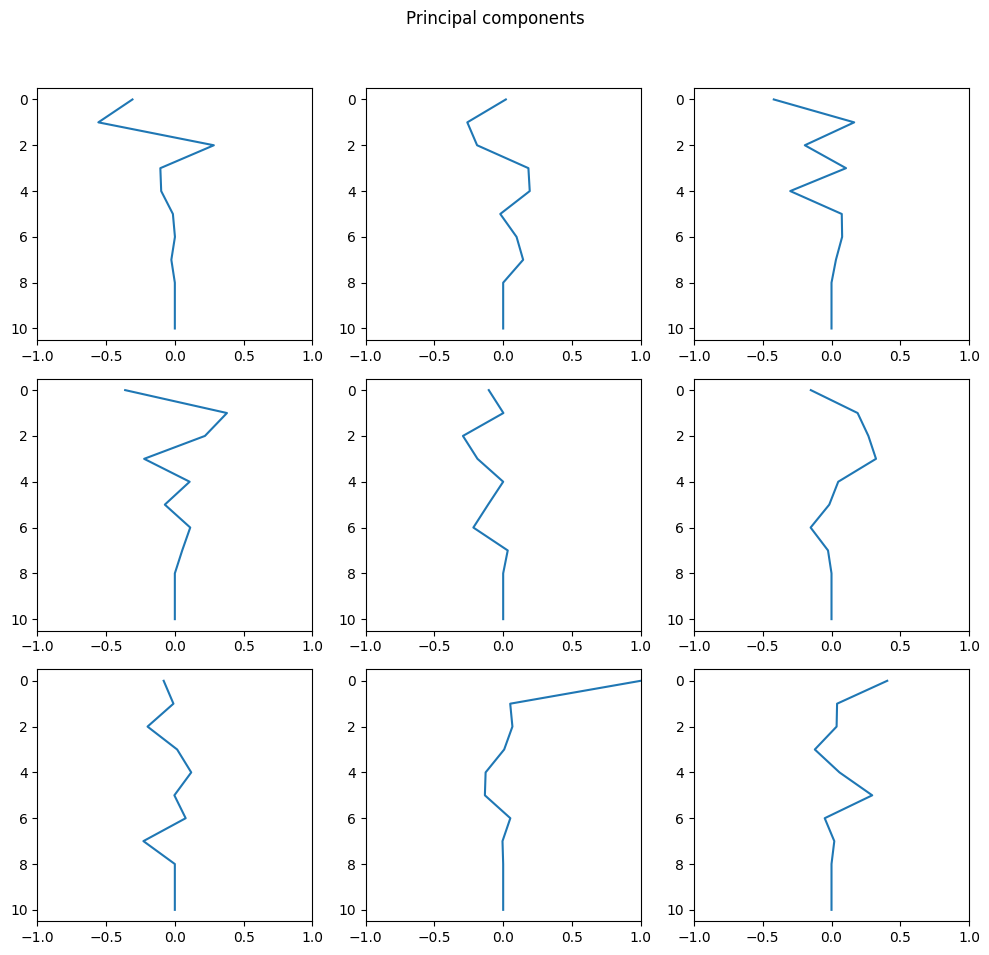

In [27]:


plot_logs_images(principal_components, pos_pca_xlim, title='Principal components')


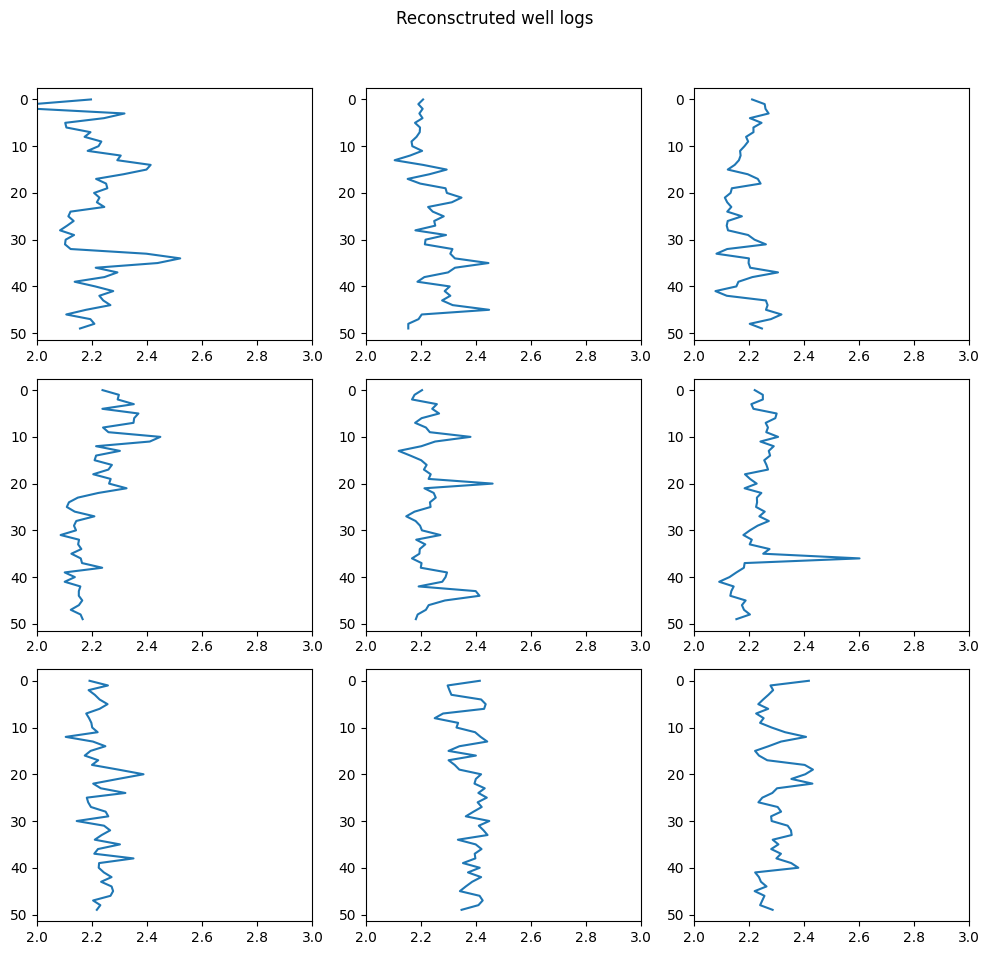

In [28]:
# --- 7. Reconstruct data --- #

rhob_matrix_reconstructed = reconstruct_well_logs(principal_components, projection_matrix, mean_vector)
plot_logs_images(rhob_matrix_reconstructed, pre_pca_xlim, title='Reconstructed well logs')

In [29]:
# --- 8. Reconstruct data --- #
error_var = computeRecError(rhob_matrix, rhob_matrix_reconstructed)
print('Reconstruction error ', error_var)

Reconstruction error  3.593699679340165e-30
